# Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import datasets
from skimage import feature

# Dataset

## Utility Functions

In [22]:
alpha = 1.4  # Contrast control (1.0-3.0)
beta =7 

In [20]:


def increase_contrast(image, alpha, beta):
    # Apply contrast adjustment formula
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

# Read grayscale image
image = (faces['images'][0]*255).astype('uint8')
# Define contrast parameters
alpha = 1.4  # Contrast control (1.0-3.0)
beta =7    # Brightness control (0-100)

# Increase contrast
adjusted_img = increase_contrast(image, alpha, beta)


NameError: name 'faces' is not defined

In [42]:
# Function to generate image pairs
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])
    
    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pos_image = increase_contrast((pos_image*255).astype('uint8'), alpha, beta)
        pos_image=pos_image/255
    
        image = increase_contrast((image*255).astype('uint8'), alpha, beta)
        image=image/255
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        neg_image = increase_contrast((neg_image*255).astype('uint8'), alpha, beta)
        neg_image=neg_image/255
        
        pair_images.append((image, neg_image))
        pair_labels.append(0)
        
    return np.array(pair_images), np.array(pair_labels)

In [70]:
faces=datasets.fetch_olivetti_faces() 

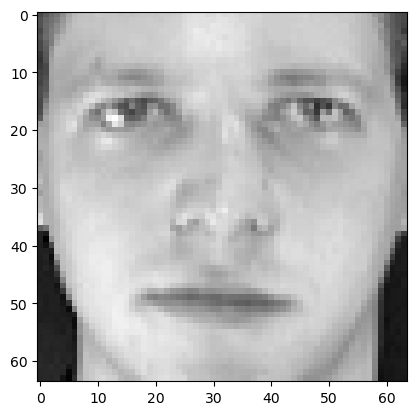

In [71]:
plt.imshow(faces['images'][0],cmap='gray')


In [72]:
adjusted_img = increase_contrast(image, alpha, beta)
edges = cv2.Canny(image=adjusted_img, threshold1=70, threshold2=70) # Canny Edge Detection



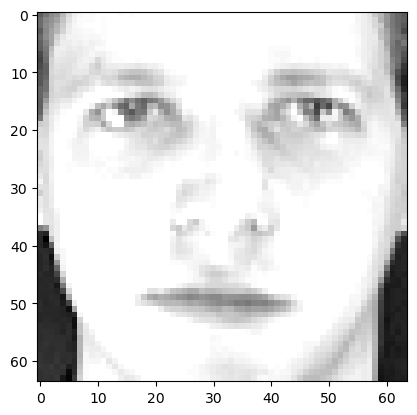

In [73]:
plt.imshow(adjusted_img/255,cmap='gray' )

In [74]:

# Canny Edge Detection
edges = cv2.Canny(image=adjusted_img, threshold1=50, threshold2=70) # Canny Edge Detection



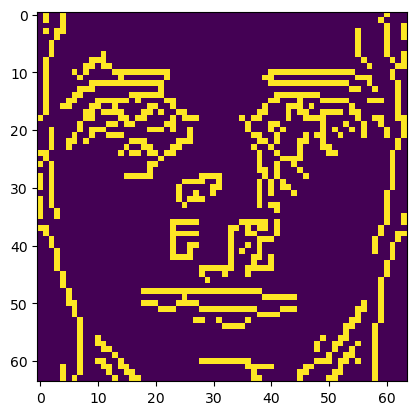

In [75]:
plt.imshow(edges)

## Prepare Data

In [76]:
# Load the images and labels
face_images =faces['images']
face_labels =faces['target']

In [77]:
target_shape = face_images[0].shape

In [78]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

## Visualize

In [79]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image,cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

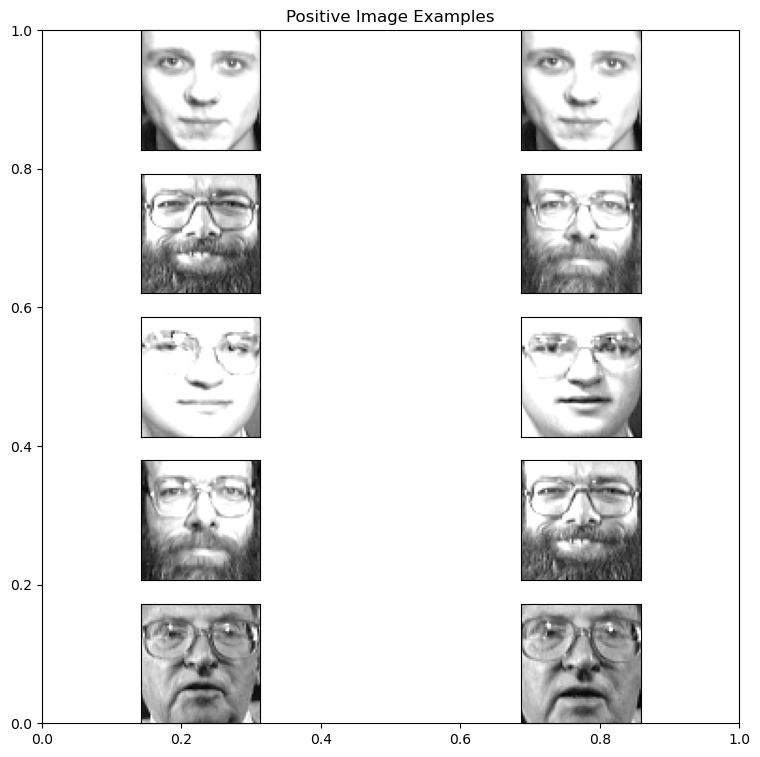

In [80]:
# Visualize Positive Images
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

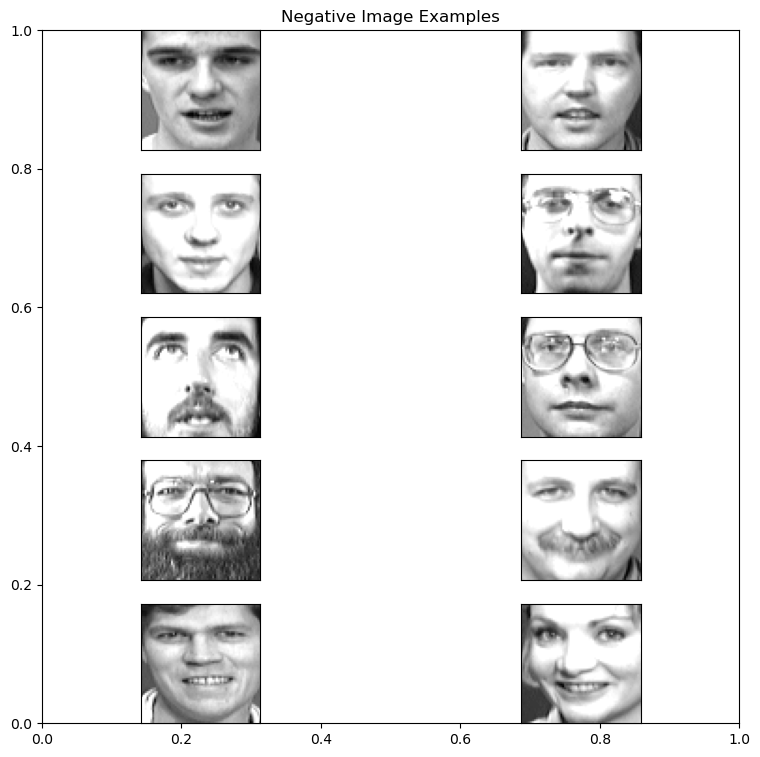

In [81]:
# Visualize Negative Images
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

# Network Architecture

## Embedding Layer

In [82]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)

fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

## Siamese Network

In [6]:
import tensorflow.keras.backend as K

In [7]:

# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [10]:
#L2 Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [9]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

NameError: name 'target_shape' is not defined

In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

# Training

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers.legacy import SGD

In [88]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

opt = "adam"



siamese_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64 ,callbacks = [early_stopping_callback])


Epoch 1/150
10/10 [==============================] - 26s 3s/step - loss: 0.6879 - accuracy: 0.5016 - val_loss: 0.6727 - val_accuracy: 0.5813
Epoch 2/150
10/10 [==============================] - 24s 2s/step - loss: 0.6687 - accuracy: 0.5016 - val_loss: 0.6689 - val_accuracy: 0.6000
Epoch 3/150
10/10 [==============================] - 25s 3s/step - loss: 0.6604 - accuracy: 0.5016 - val_loss: 0.6851 - val_accuracy: 0.6625
Epoch 4/150
10/10 [==============================] - 28s 3s/step - loss: 0.6396 - accuracy: 0.5031 - val_loss: 0.6492 - val_accuracy: 0.6000
Epoch 5/150
10/10 [==============================] - 24s 2s/step - loss: 0.6350 - accuracy: 0.5172 - val_loss: 0.6608 - val_accuracy: 0.6625
Epoch 6/150
10/10 [==============================] - 23s 2s/step - loss: 0.6349 - accuracy: 0.5406 - val_loss: 0.6931 - val_accuracy: 0.5063
Epoch 7/150
10/10 [==============================] - 24s 2s/step - loss: 0.6415 - accuracy: 0.5281 - val_loss: 0.6384 - val_accuracy: 0.6500
Epoch 8/150
1

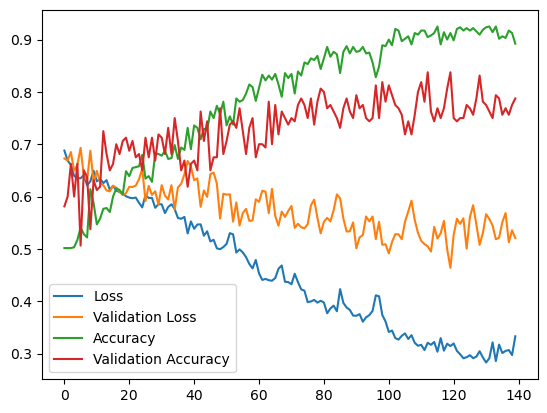

In [90]:
 # Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])

In [484]:
#Reload_model
siamese_model_save = tf.keras.models.load_model('siamesemodel_ollivetti_150.h5', custom_objects={'DistanceLayer':DistanceLayer, 'binary_crossentropy':tf.losses.BinaryCrossentropy})

In [13]:
siamese_model_save = tf.keras.models.load_model('siamesemodel_ollivetti_contrast_150.keras', custom_objects={'DistanceLayer':DistanceLayer, 'binary_crossentropy':tf.losses.BinaryCrossentropy})

# Testing

In [678]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

## Test 

In [679]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10, 20), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    image = increase_contrast((image*255).astype('uint8'), alpha, beta)
    image=image/255
    compare_images.append(image)

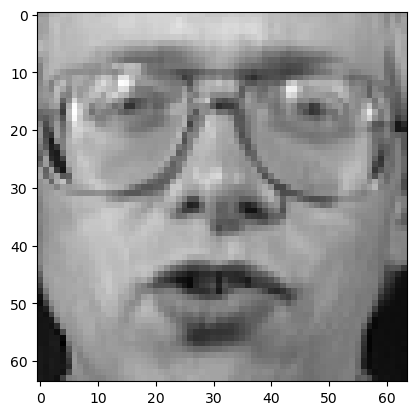

In [680]:
plt.imshow(test_image,cmap='gray')

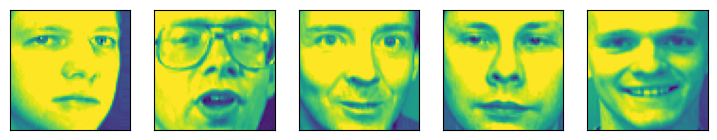

In [681]:
test_visualize(compare_images)

In [682]:
image_pairs = []
image = test_image
test_image = increase_contrast((image*255).astype('uint8'), alpha, beta)
test_image=test_image/255
for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

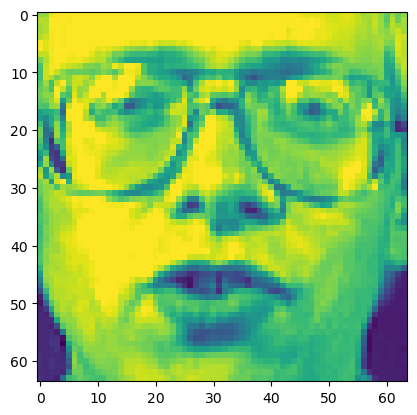

In [683]:
plt.imshow(image_pairs[0][0])

In [684]:
score = siamese_model_save.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

1/1 [==============================] - 0s 174ms/step


In [685]:
print(score)

[[0.60107344]
 [0.5845526 ]
 [0.04640693]
 [0.02484934]
 [0.02274266]]


In [686]:
image_pairs[:, 0, :][0].shape

(64, 64)

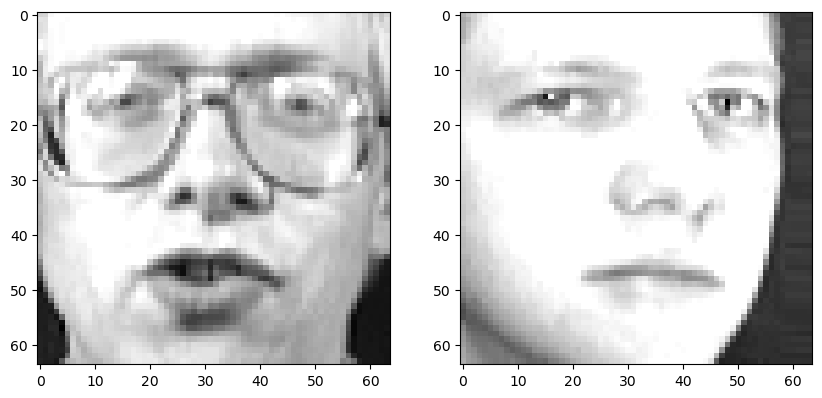

[0.60107344]


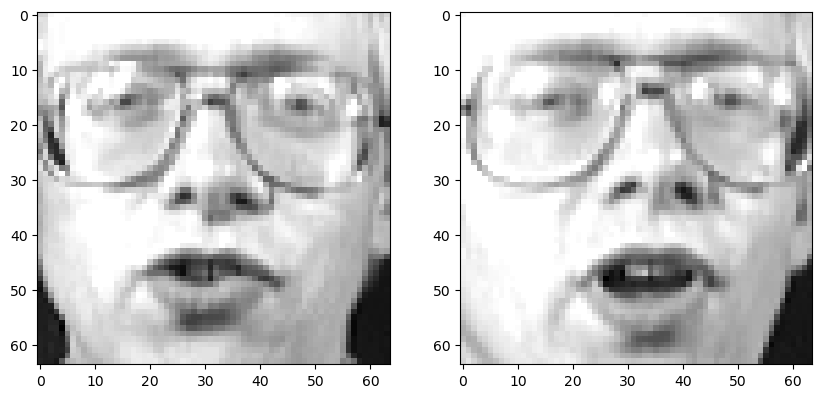

[0.5845526]


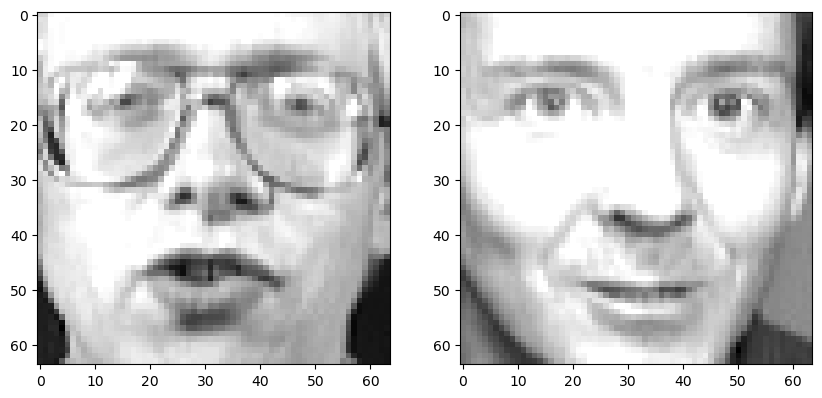

[0.04640693]


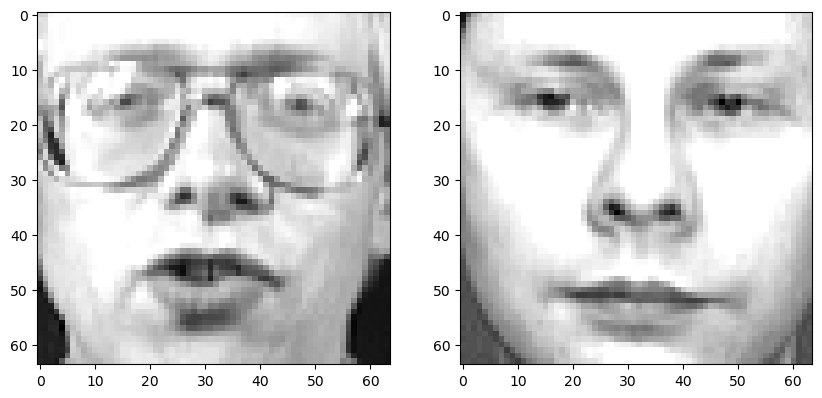

[0.02484934]


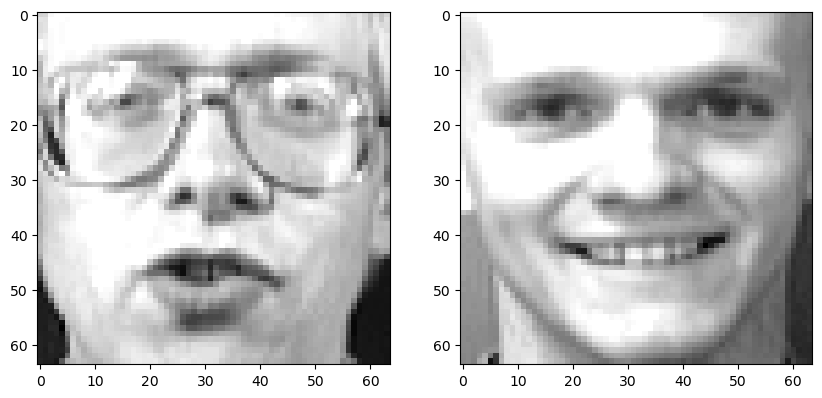

[0.02274266]


In [687]:
p=0
while(p<5):
    
    plt.figure(figsize=(10,8))

    # Set first subplot
    plt.subplot(1,2,1)
    
    plt.imshow(image_pairs[:, 0, :][p],cmap='gray')

    # Set second subplot
    plt.subplot(1,2,2)
    
    plt.imshow(image_pairs[:, 1, :][p],cmap='gray')
    plt.show()
    print(score[p])
    p=p+1



# Face detection

In [688]:
pip install mtcnn

Note: you may need to restart the kernel to use updated packages.


In [18]:
from mtcnn.mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
detector = MTCNN()
def face_detect(path):
    image_mtcnn = cv2.imread(path)
    faces = detector.detect_faces(image_mtcnn)
    for face in faces:
        box = face['box']
        conf = face['confidence']
        print("confidence: ", conf)
        x, y, w, h = box[0], box[1], box[2], box[3]


        cv2.putText(image_mtcnn, str(conf), (x, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), thickness=4)
        #cv2.rectangle(image_mtcnn, (x, y), (x+w, y+h) ,(0,0, 0), 0)
        face = image_mtcnn[y:y + h+20, x:x + w+20]
    return face

#cv2.imwrite("/content/drive/MyDrive/face/face2.jpg", face)

In [690]:
face=face_detect("/Users/sachisingh/Downloads/IMG_8051.jpeg")

1/1 [==============================] - 0s 44ms/step
confidence:  0.9982330799102783


# TESTING ON UNSEEN IMAGES

In [692]:
compare_images[0].shape

(64, 64)

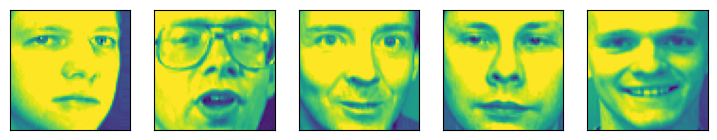

In [693]:
test_visualize(compare_images)

In [ ]:

img=face_detect("/Users/sachisingh/Downloads/IMG_8051.jpeg")


In [695]:
def pre(path):
    img=cv2.imread(path)

    frame2 = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(frame2, (64,64))
    resized_frame= increase_contrast((resized_frame).astype('uint8'), alpha, beta)
    img= resized_frame / 255
    return img
img1=pre("/Users/sachisingh/Downloads/IMG_8051.jpeg")

img3=pre("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/img2.jpeg")


In [696]:
def pre_test(test):
    frame2 = cv2.cvtColor(np.array(test), cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(frame2, (64,64))
    resized_frame= increase_contrast((resized_frame).astype('uint8'), alpha, beta)
    img= resized_frame / 255
    return img

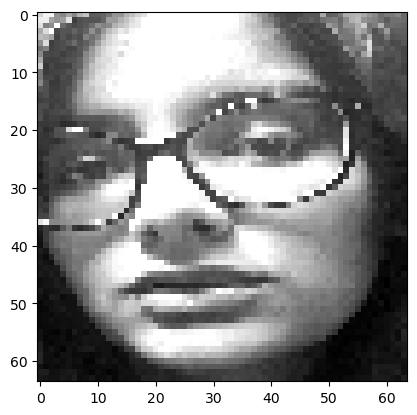

In [698]:
img=pre_test(img)
plt.imshow(img,cmap='gray')

In [699]:
score = siamese_model_save.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

1/1 [==============================] - 0s 174ms/step


In [701]:

compare_images.append(img)

In [702]:
image_pairs = []
for image in compare_images:
    image_pairs.append((img, image))

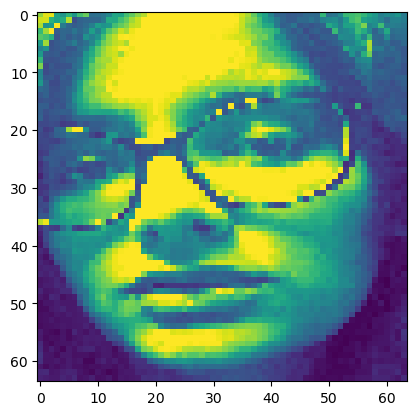

In [703]:
plt.imshow(image_pairs[1][0])

In [704]:

score = siamese_model_save.predict([np.expand_dims(img,axis=0), np.expand_dims(img3,axis=0)])
print(score)

1/1 [==============================] - 0s 33ms/step
[[0.5943631]]


#see how the model responds with diff images in the same lighting

# Similarity testing in different angles/expressions/lighting

In [705]:
test1=face_detect("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/test1.jpg")
test2=face_detect("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/test2.jpg")


1/1 [==============================] - 0s 9ms/step
confidence:  0.9999618530273438
1/1 [==============================] - 0s 9ms/step
confidence:  0.9999436140060425


In [35]:
def inc_brightness(img):
    alpha = 1.55  # Contrast control (1.0-3.0)
    beta =9    # Brightness control (0-100)

    # Increase contrast
    img = increase_contrast((img)*255, alpha, beta)
    return img/255

1/1 [==============================] - 0s 8ms/step
confidence:  0.9982330799102783


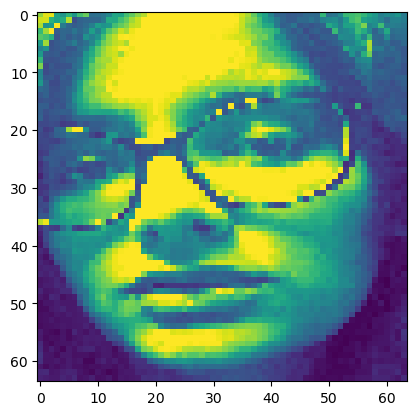

In [276]:
face=face_detect("/Users/sachisingh/Downloads/IMG_8051.jpeg")
face=pre_test(face)
plt.imshow(face)

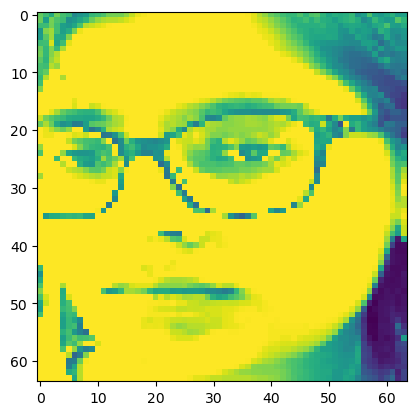

In [277]:
plt.imshow(test1)

In [279]:
#different angles
score = siamese_model_save.predict([np.expand_dims(test1,axis=0), np.expand_dims(test2,axis=0)])
print(score)

1/1 [==============================] - 0s 83ms/step
[[0.5969846]]


In [280]:
#different lighing
score = siamese_model_save.predict([np.expand_dims(test2,axis=0), np.expand_dims(face,axis=0)])
print(score)

1/1 [==============================] - 0s 43ms/step
[[0.5901051]]


 observe that the network is performing well with unseen images with tolerence to some side movement this is because in the dataset All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).

# Angles

In [ ]:
a=face_detect("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/0.jpg")
a=pre_test(a)
a=inc_brightness(a)

1/1 [==============================] - 0s 8ms/step
confidence:  0.9999290704727173


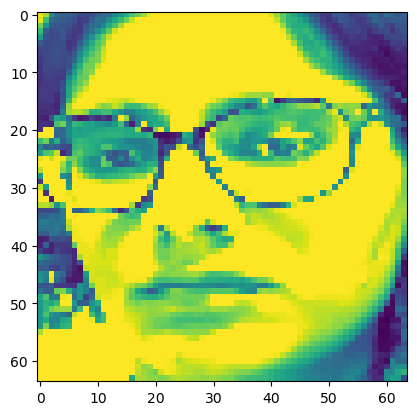

In [284]:
b=face_detect("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/15.jpg")
b=pre_test(b)
b=inc_brightness(b)
plt.imshow(b)

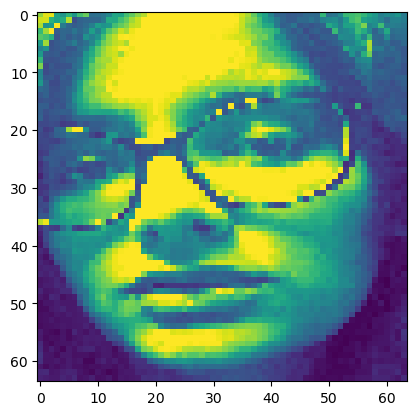

In [285]:
plt.imshow(img)

1/1 [==============================] - 0s 9ms/step
confidence:  0.9999669790267944


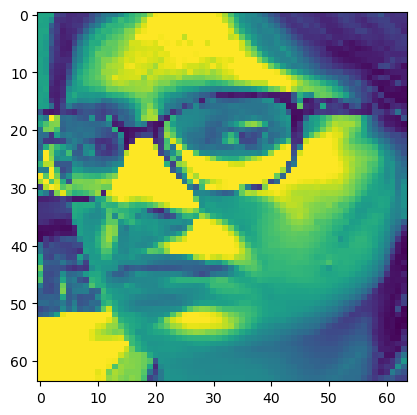

In [286]:
c=face_detect("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/45.jpg")
c=pre_test(c)
plt.imshow(c)

In [289]:
c=inc_brightness(c)

In [293]:
score = siamese_model_save.predict([np.expand_dims(c,axis=0), np.expand_dims(img,axis=0)])
print(score)

1/1 [==============================] - 0s 39ms/step
[[0.5513411]]


# Testing_on_guard_dataset

In [16]:
guard_ref=face_detect("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/guard_ref.jpeg")

1/1 [==============================] - 0s 94ms/step
confidence:  0.9999812841415405


# reference_image

In [58]:
def pre_test(test):
    frame2 = cv2.cvtColor(np.array(test), cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(frame2, (64,64))
    resized_frame= increase_contrast((resized_frame).astype('uint8'), alpha, beta)
    img= resized_frame / 255
    return img

In [59]:
guard_ref=pre_test(guard_ref)

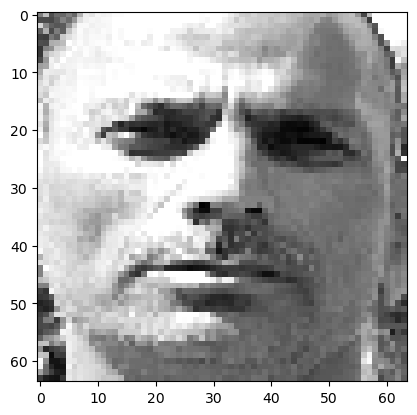

In [60]:
plt.imshow(guard_ref,cmap='gray')

In [61]:
guard_ref=inc_contrast(guard_ref)

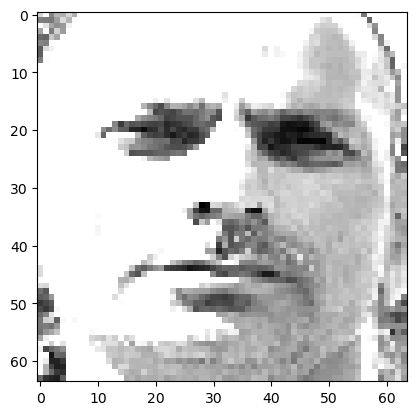

In [62]:
plt.imshow(guard_ref,cmap='gray')

In [957]:
guard1=face_detect("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/gi1.png")

1/1 [==============================] - 0s 12ms/step
confidence:  0.9937655925750732


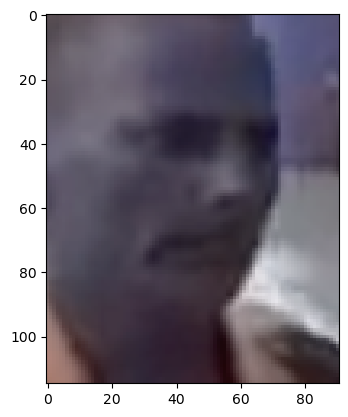

In [958]:
plt.imshow(guard1,cmap='gray')

In [959]:

gray = cv2.cvtColor(guard1, cv2.COLOR_BGR2GRAY)

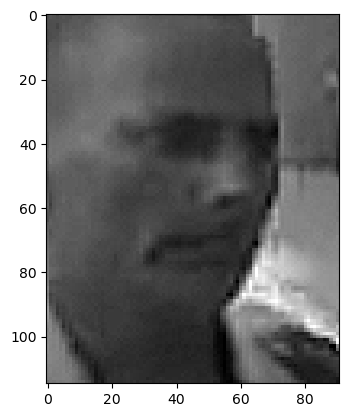

In [960]:
kernel = np.array([[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]])
sharpened = cv2.filter2D(gray, -1, kernel)
plt.imshow(sharpened, cmap='gray')

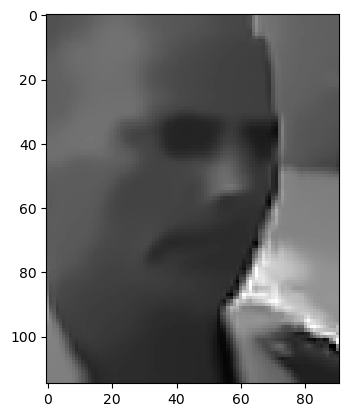

In [961]:

denoised_image = cv2.fastNlMeansDenoising(sharpened , None, 10, 7, 21)

plt.imshow(denoised_image, cmap='gray')

In [962]:
def pre_test(test):

    resized_frame = cv2.resize(test, (64,64))
    resized_frame= increase_contrast((resized_frame).astype('uint8'), alpha, beta)
    img= resized_frame / 255
    return img

In [963]:
guard1=pre_test(sharpened)

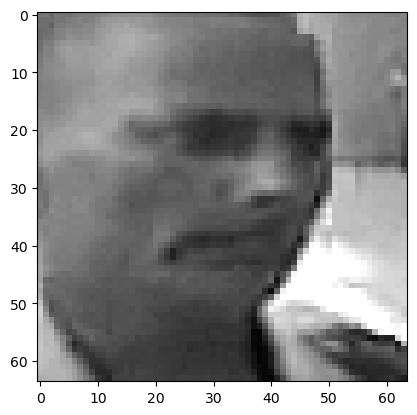

In [964]:
plt.imshow(guard1,cmap='gray')

In [37]:

def inc_contrast2(img):
    alpha =2.5  # Contrast control (1.0-3.0)
    beta =10  # Brightness control (0-100)

    # Increase contrast
    img = increase_contrast((img)*255, alpha, beta)
    return img/255


In [966]:
g=inc_contrast2(guard1)


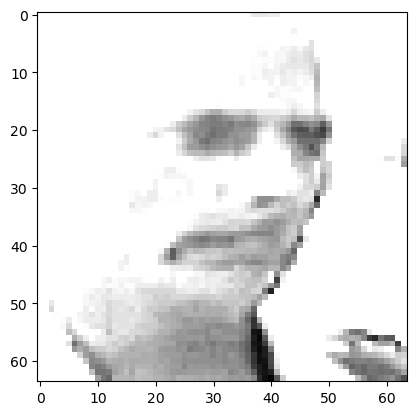

In [967]:
plt.imshow(g,cmap='gray')

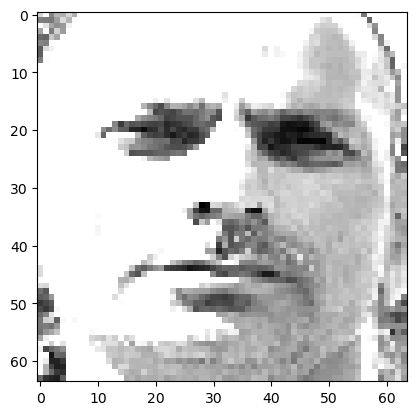

In [968]:
plt.imshow(guard_ref,cmap='gray')

In [969]:

score = siamese_model_save.predict([np.expand_dims(guard_ref,axis=0), np.expand_dims(g,axis=0)])
print(score)

1/1 [==============================] - 0s 56ms/step
[[0.489502]]


In [1103]:
guard2=face_detect("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/further.png")

1/1 [==============================] - 0s 10ms/step
confidence:  0.9993270635604858


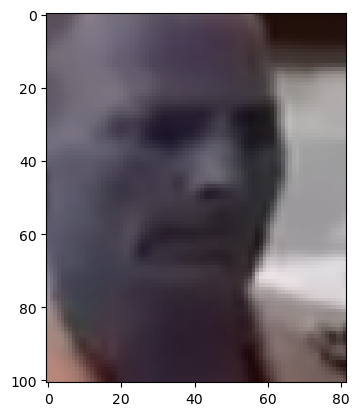

In [1104]:
plt.imshow(guard2,cmap='gray')


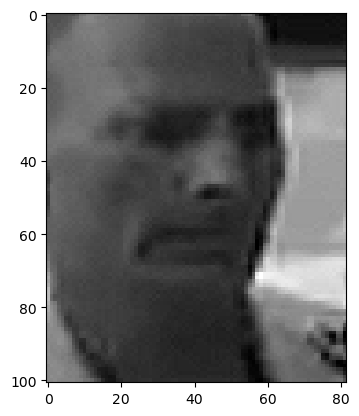

In [1105]:
gray = cv2.cvtColor(guard2, cv2.COLOR_BGR2GRAY)
kernel = np.array([[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]])
sharpened = cv2.filter2D(gray, -1, kernel)
plt.imshow(sharpened, cmap='gray')

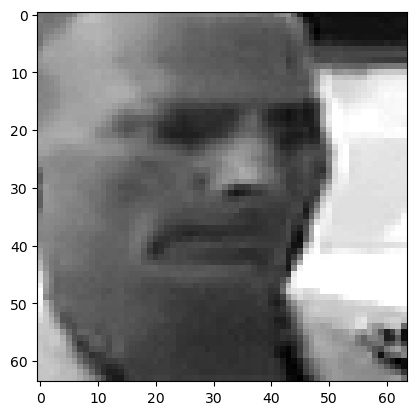

In [1106]:

def pre_test(test):

    resized_frame = cv2.resize(test, (64,64))
    resized_frame= increase_contrast((resized_frame).astype('uint8'), alpha, beta)
    img= resized_frame / 255
    return img
guard1=pre_test(sharpened)
plt.imshow(guard1,cmap='gray')


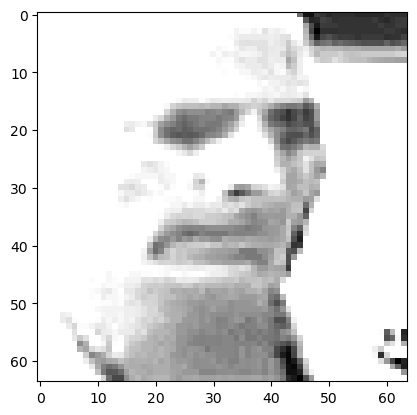

In [1107]:

def inc_contrast2(img):
    alpha =2.5  # Contrast control (1.0-3.0)
    beta =10  # Brightness control (0-100)

    # Increase contrast
    img = increase_contrast((img)*255, alpha, beta)
    return img/255
g2=inc_contrast2(guard1)
plt.imshow(g2,cmap='gray')

In [1109]:
score = siamese_model_save.predict([np.expand_dims(guard_ref,axis=0), np.expand_dims(g2,axis=0)])
print(score)

1/1 [==============================] - 0s 79ms/step
[[0.51400787]]


# achieved 0.5+ similarity 

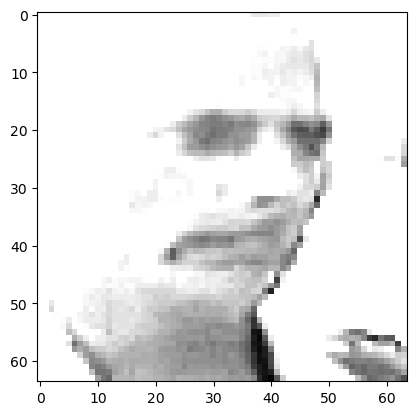

In [1110]:
plt.imshow(g,cmap='gray')

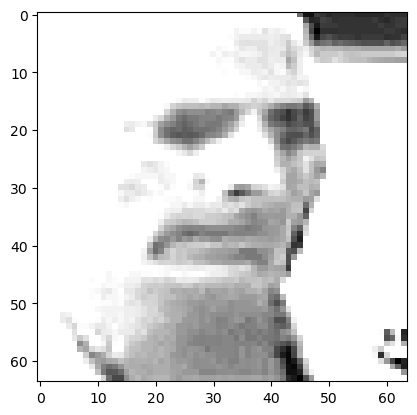

In [1111]:
plt.imshow(g2,cmap='gray')

In [1112]:

score = siamese_model_save.predict([np.expand_dims(g,axis=0), np.expand_dims(g2,axis=0)])
print(score)

1/1 [==============================] - 0s 82ms/step
[[0.51077527]]


# FUNCTION TO PREPROCESS VIDEO frames

In [15]:
def face_detect_image(image):

    faces = detector.detect_faces(image)
    l=[]
    for face2 in faces:
        box = face2['box']
        conf = face2['confidence']
        print("confidence: ", conf)
        x, y, w, h = box[0], box[1], box[2], box[3]
        face2 = image[y:y + h, x:x + w+10]
   
        l.append(face2)

    return l,box


def pre_test(test):

    resized_frame = cv2.resize(test, (64,64))
    resized_frame= increase_contrast((resized_frame).astype('uint8'), alpha, beta)
    img= resized_frame / 255
    return img

def inc_contrast2(img,   alpha, beta):
      # Brightness control (0-100)

    # Increase contrast
    img = increase_contrast((img)*255, alpha, beta)
    return img/255


def check_image(a,b,path):
    g=face_detect(path)
    gray = cv2.cvtColor(g, cv2.COLOR_BGR2GRAY)
    
    kernel = np.array([[0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]])
    
    sharpened = cv2.filter2D(gray, -1, kernel)

    g=pre_test(sharpened)
    

    img=inc_contrast2(g,a,b)
    return img
    
def check_image2(a,b,img):
    
    g=face_detect_image(img)
    print(g)
    gray = cv2.cvtColor(g[0], cv2.COLOR_BGR2GRAY)
    
    kernel = np.array([[0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]])
    
    sharpened = cv2.filter2D(gray, -1, kernel)

    g=pre_test(sharpened)
    

    img=inc_contrast2(g,a,b)
    return img


1/1 [==============================] - 0s 10ms/step
confidence:  0.9990684390068054


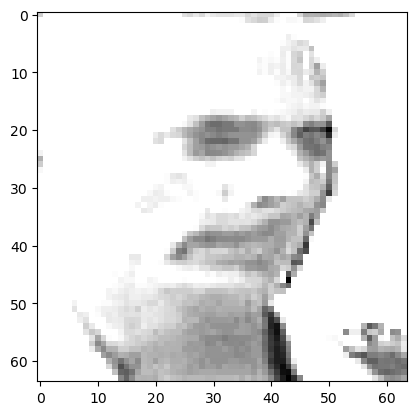

In [1318]:
img=check_image(2.5,10,"/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/guard_test.jpg")
plt.imshow(img,cmap='gray')

In [1528]:

score = siamese_model_save.predict([np.expand_dims(g,axis=0), np.expand_dims(img,axis=0)])
print(score)

1/1 [==============================] - 1s 1s/step
[[0.5322601]]


testing guards image with other images

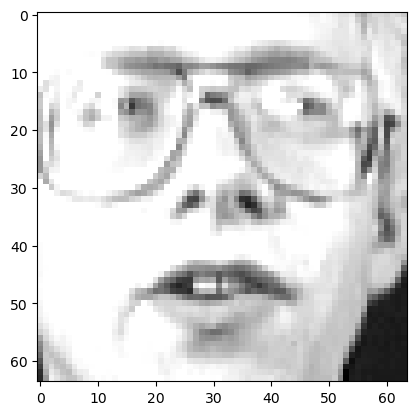

In [1274]:
test_image=inc_brightness(test_image)
plt.imshow(test_image,cmap='gray')

In [659]:
score = siamese_model_save.predict([np.expand_dims(test_image,axis=0), np.expand_dims(guard_ref,axis=0)])
print(score)

1/1 [==============================] - 0s 35ms/step
[[0.29606387]]


In [660]:
score = siamese_model_save.predict([np.expand_dims(test_image,axis=0), np.expand_dims(g,axis=0)])
print(score)

1/1 [==============================] - 0s 85ms/step
[[0.283655]]


In [1101]:
score = siamese_model_save.predict([np.expand_dims(test_image,axis=0), np.expand_dims(g2,axis=0)])
print(score)

1/1 [==============================] - 0s 95ms/step
[[0.23813485]]


In [1102]:
score = siamese_model_save.predict([np.expand_dims(a,axis=0), np.expand_dims(g2,axis=0)])
print(score)

1/1 [==============================] - 0s 60ms/step
[[0.28718415]]


In [16]:

def pre_test(test):

    resized_frame = cv2.resize(test, (64,64))
    resized_frame= increase_contrast((resized_frame).astype('uint8'), alpha, beta)
    img= resized_frame / 255
    return img

def inc_contrast2(img,   alpha, beta):
      # Brightness control (0-100)

    # Increase contrast
    img = increase_contrast((img)*255, alpha, beta)
    return img/255

def face_detect_image(image):

    faces = detector.detect_faces(image)
    l=[]
    for face2 in faces:
        box = face2['box']
        conf = face2['confidence']
        print("confidence: ", conf)
        x, y, w, h = box[0], box[1], box[2], box[3]
        face2 = image[y:y + h, x:x + w+10]
   
        l.append(face2)

    return l,box



    
def check_image2(a,b,img):
    
    g,box=face_detect_image(img)

    gray = cv2.cvtColor(g[0], cv2.COLOR_BGR2GRAY)
    
    kernel = np.array([[0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]])
    
    sharpened = cv2.filter2D(gray, -1, kernel)

    g=pre_test(sharpened)
    

    img=inc_contrast2(g,a,b)
    return img,box


# Predict on video

In [75]:

tt=[]
s=[]
def predict_on_video(video_file_path, output_file_path):
 

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))


    predicted_class_name = ''

    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 

        if not ok:
            break
        frame2=cv2.flip(frame, 0)
        
        try:
           
            frame2,box=check_image2(2.5,10,frame2)
            tt.append(frame2)
            
            result = siamese_model_save.predict([np.expand_dims(guard_ref,axis=0),np.expand_dims(frame2, axis=0)])
            s.append(result)
            if( result > 0.302):
     
              
                verified="True"
            else:
                verified="False"
       
            print(result)
            frame=cv2.flip(frame, 0)
            cv2.putText(frame,  verified ,(10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            x, y, w, h = box[0], box[1], box[2], box[3]

            cv2.rectangle(frame, box, (0, 255, 0), 2)
            cv2.putText(frame,str(result), (90, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), thickness=4)

            video_writer.write(frame)
            
            plt.imshow(frame)
        except:
            continue
    video_reader.release()
    video_writer.release()


In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'testA_videos'
os.makedirs(test_videos_directory, exist_ok = True)

output_video_file_path = f'{test_videos_directory}/Output_final.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(r'/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/guard.mp4',output_video_file_path)

1/1 [==============================] - 0s 10ms/step
confidence:  0.992866039276123
1/1 [==============================] - 0s 93ms/step
[[0.42846644]]
1/1 [==============================] - 0s 12ms/step
confidence:  0.9952470660209656
1/1 [==============================] - 0s 35ms/step
[[0.43042228]]
1/1 [==============================] - 0s 11ms/step
confidence:  0.9935258626937866
1/1 [==============================] - 0s 26ms/step
[[0.35882443]]
1/1 [==============================] - 0s 11ms/step
confidence:  0.9842939972877502
1/1 [==============================] - 0s 30ms/step
[[0.27194643]]
1/1 [==============================] - 0s 10ms/step
confidence:  0.9894493222236633
1/1 [==============================] - 0s 30ms/step
[[0.32082376]]
1/1 [==============================] - 0s 12ms/step
confidence:  0.9652022123336792
1/1 [==============================] - 0s 31ms/step
[[0.4112305]]
1/1 [==============================] - 0s 10ms/step
confidence:  0.9853506088256836
1/1 [=======

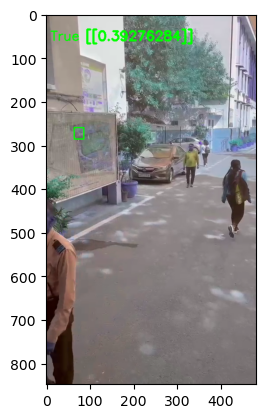

In [76]:
# Make the Output directory if it does not exist
test_videos_directory = 'testA_videos'
os.makedirs(test_videos_directory, exist_ok = True)

output_video_file_path = f'{test_videos_directory}/Output_final.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(r'/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/test_images/guard.mp4',output_video_file_path)

In [ ]:
plt.imshow(guard_ref,cmap='gray')

In [66]:
len(tt)

77

[[0.09711997]]


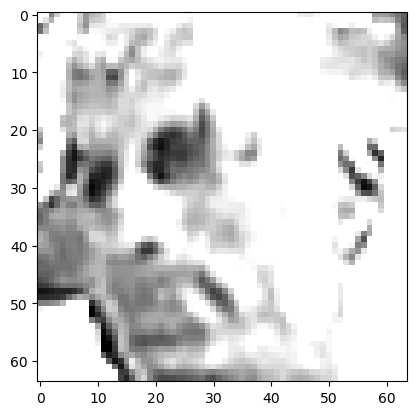

In [67]:
plt.imshow(tt[15],cmap='gray')
print(s[15])

[[0.44078955]]


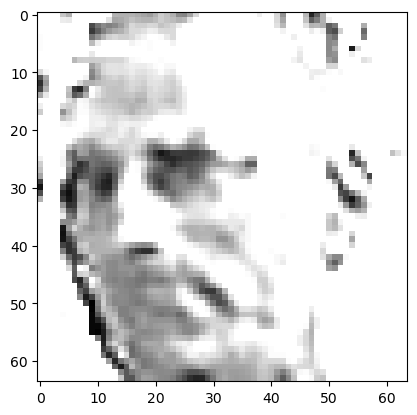

In [1537]:

plt.imshow(tt[10],cmap='gray')
print(s[10])

In [1570]:
score = siamese_model_save.predict([np.expand_dims(tt[10],axis=0), np.expand_dims(x,axis=0)])
print(score)

1/1 [==============================] - 0s 26ms/step
[[0.03935822]]


In [1561]:
score = siamese_model_save.predict([np.expand_dims(tt[9],axis=0), np.expand_dims(tt[9],axis=0)])
print(score)

1/1 [==============================] - 0s 80ms/step
[[0.60466236]]


# TESTING (SELF DATASET)

In [32]:
anchor=os.listdir("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/data/anchor")
pos=os.listdir("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/data/positive")
neg=os.listdir("/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/data/negative")

In [ ]:
#1,10==contrast,brightness

In [23]:
i=check_image(1.6,10,"/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/data/anchor/d41c6370-bc48-11ee-9d39-368ad70eb3dd.jpg")

1/1 [==============================] - 0s 8ms/step
confidence:  0.9993658661842346


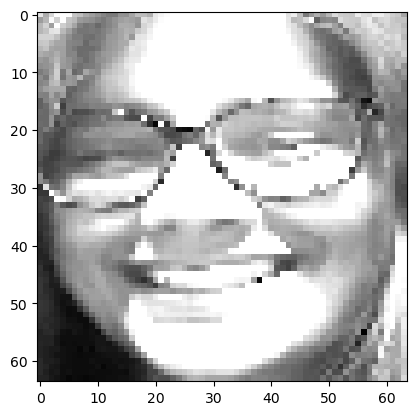

In [24]:
plt.imshow(i,cmap='gray')

In [27]:
i2=check_image(1,10,"/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/data/anchor/d61e39dc-bc48-11ee-9d39-368ad70eb3dd.jpg")

1/1 [==============================] - 0s 7ms/step
confidence:  0.9992341995239258


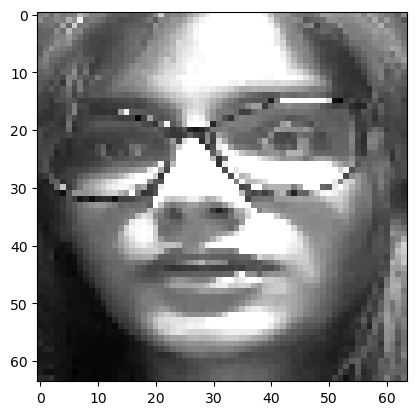

In [28]:
plt.imshow(i2,cmap='gray')

In [1207]:
score = siamese_model_save.predict([np.expand_dims(i2,axis=0), np.expand_dims(i,axis=0)])
print(score)

1/1 [==============================] - 0s 33ms/step
[[0.51979554]]


In [40]:
a="/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/data/anchor/"
p="/Users/sachisingh/Library/CloudStorage/OneDrive-Personal/Desktop/major_project_8th/data/positive/"
num=0
true=0
s=[]
t=[]
r=[]
s2=[]
t2=[]
r2=[]
for i,j in zip(anchor,pos):
    num=num+1
    
    try:
        x=check_image(1,10,a+i)
        y=check_image(1,10,p+j)
        score = siamese_model_save.predict([np.expand_dims(x,axis=0), np.expand_dims(y,axis=0)])
        print(score)
        
        if(score>0.5):
            true=true+1
            s.append(score)
            t.append(x)
            r.append(y)
        else:
            s2.append(score)
            t2.append(x)
            r2.append(y)
            
    except:
        continue

    

1/1 [==============================] - 0s 8ms/step
confidence:  0.9927210211753845
1/1 [==============================] - 0s 8ms/step
confidence:  0.9798732995986938
1/1 [==============================] - 0s 83ms/step
[[0.27083123]]
1/1 [==============================] - 0s 9ms/step
confidence:  0.9957016110420227
1/1 [==============================] - 0s 9ms/step
confidence:  0.9999362230300903
1/1 [==============================] - 0s 31ms/step
[[0.35917035]]
1/1 [==============================] - 0s 8ms/step
confidence:  0.9950369000434875
1/1 [==============================] - 0s 8ms/step
confidence:  0.9979732632637024
1/1 [==============================] - 0s 26ms/step
[[0.6433861]]
1/1 [==============================] - 0s 8ms/step
confidence:  0.9999074935913086
1/1 [==============================] - 0s 9ms/step
confidence:  0.9999539852142334
1/1 [==============================] - 0s 26ms/step
[[0.26423758]]
1/1 [==============================] - 0s 8ms/step
confidence:  0.997

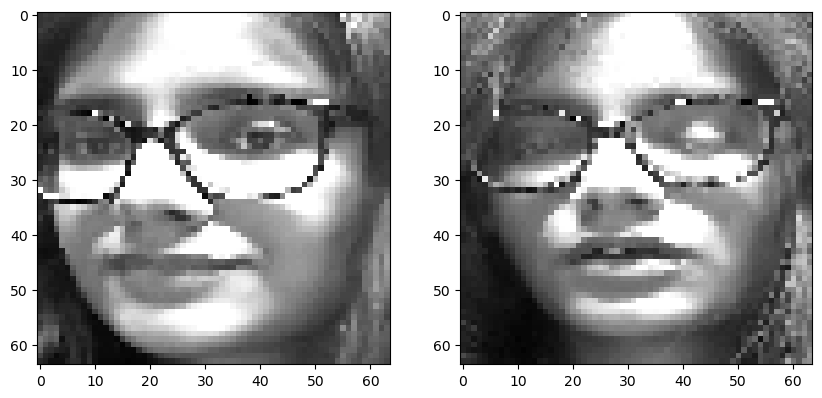

[[0.6433861]]


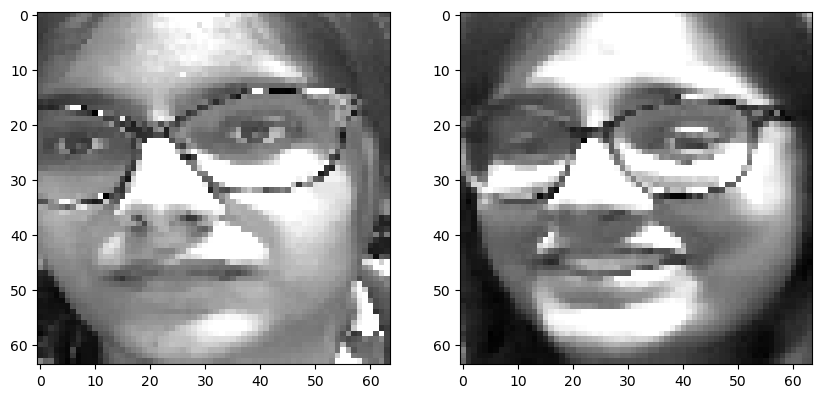

[[0.6918425]]


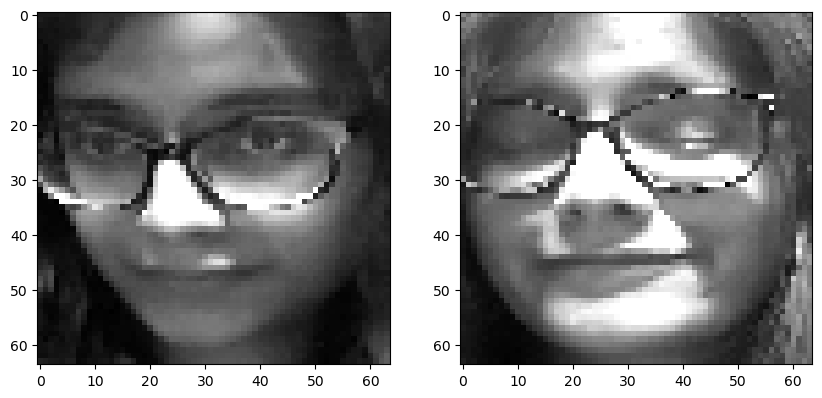

[[0.5791807]]


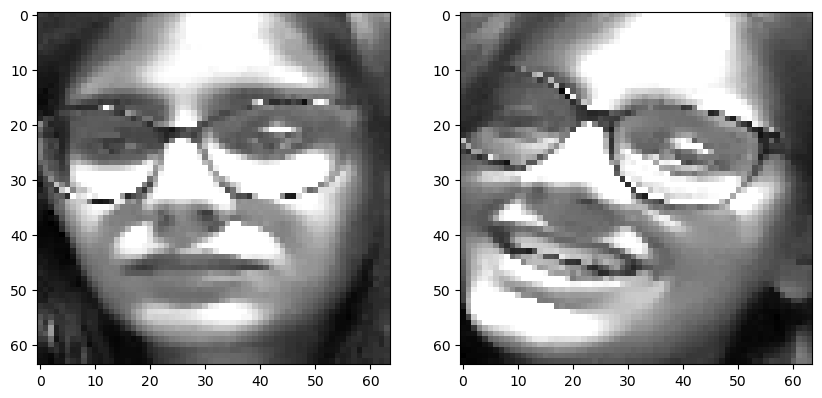

[[0.5832001]]


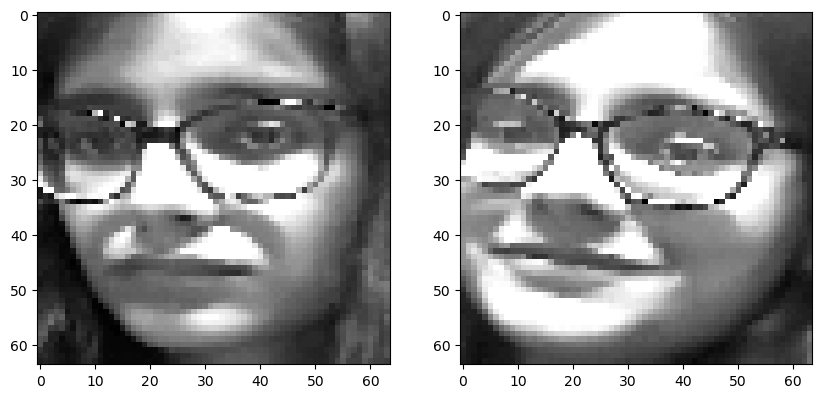

[[0.5736289]]


In [45]:
p=0
while(p<5):
    
    plt.figure(figsize=(10,8))

    # Set first subplot
    plt.subplot(1,2,1)
    
    plt.imshow(r[p],cmap='gray')

    # Set second subplot
    plt.subplot(1,2,2)
    
    plt.imshow(t[p],cmap='gray')
    plt.show()
    
    print(s[p])
    p=p+1